<a href="https://colab.research.google.com/github/Tomaz4lves/Biblioteca_pandas/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install scipy
!pip install pmdarima

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [11]:
# Carregar os dados

temp = pd.read_excel('temperature.xlsx', index_col="Date", parse_dates=True)
temp.head()

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-02-01,17.9
1981-03-01,18.8
1981-04-01,14.6
1981-05-01,15.8


In [22]:
#Limpando e organizando dados

temp['Daily minimum temperatures'] = temp['Daily minimum temperatures'].astype(float)
temp.sort_index(inplace=True)

In [23]:
#Informações

temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Daily minimum temperatures  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


<Figure size 2000x1000 with 0 Axes>

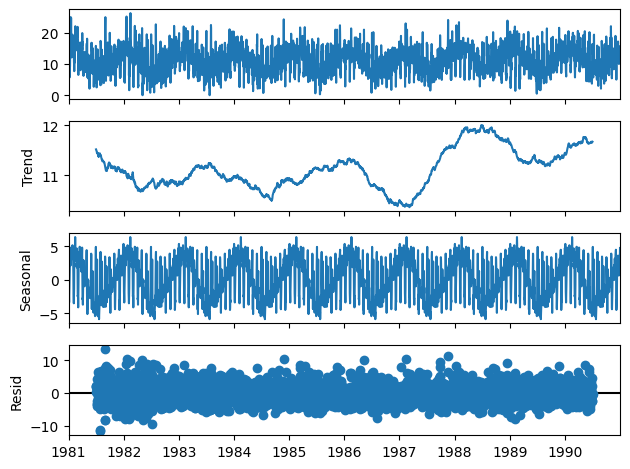

In [24]:
#Decompondo uma série temporal em seus componentes de tendência, sazonalidade e resíduos.

from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(temp, model="add", period=365)

fig = plt.figure(figsize=(20,10))
fig= resultado.plot()

In [26]:
#Teste de estacionariedade. A hipótese nula é que a série não é estacionária
#Ou seja, se o p-valor for menor que 0,05, rejeitamos que a série não é estacionária.
#Caso seja maior, não podemos descartar que a série não é estacionária


from statsmodels.tsa.stattools import adfuller

result=adfuller(temp['Daily minimum temperatures'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-3.331541412968857
p-valor:0.01352611219545271


In [27]:
#Auto ARIMA nos ajuda a buscar os melhores parâmetros

fit_arima = auto_arima(temp, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True,
                           m=6,
                           D=1,
                           start_P=1,
                           start_Q=1,
                           max_P=2,
                           max_Q=2,
                           information_criterion='aic',
                           trace=True,
                           error_action='ignore',
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=11.68 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=22211.573, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=20978.709, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=2.67 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=22068.931, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=20482.431, Time=0.68 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=9.64 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=3.30 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=20662.364, Time=0.58 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=20418.687, Time=1.19 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=20927.151, Time=0.69 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=10.92 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=5.06 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=20352.684, Time=1.67 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=20872.994, 

In [29]:
#Criando um modelo SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(temp,order=(3,1,0))
resultado_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
#Realizando um "backtesting" com predições de valores dos 12 meses anteriores

predicoes = resultado_sarimax.get_prediction(start=-60)
predicao_media = predicoes.predicted_mean

In [31]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(13.215902333969314, 26.45930394097881)

In [32]:
predicao_media[0]

19.837603137474062

In [34]:
#Converte os índices em arrays

datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(temp.index)

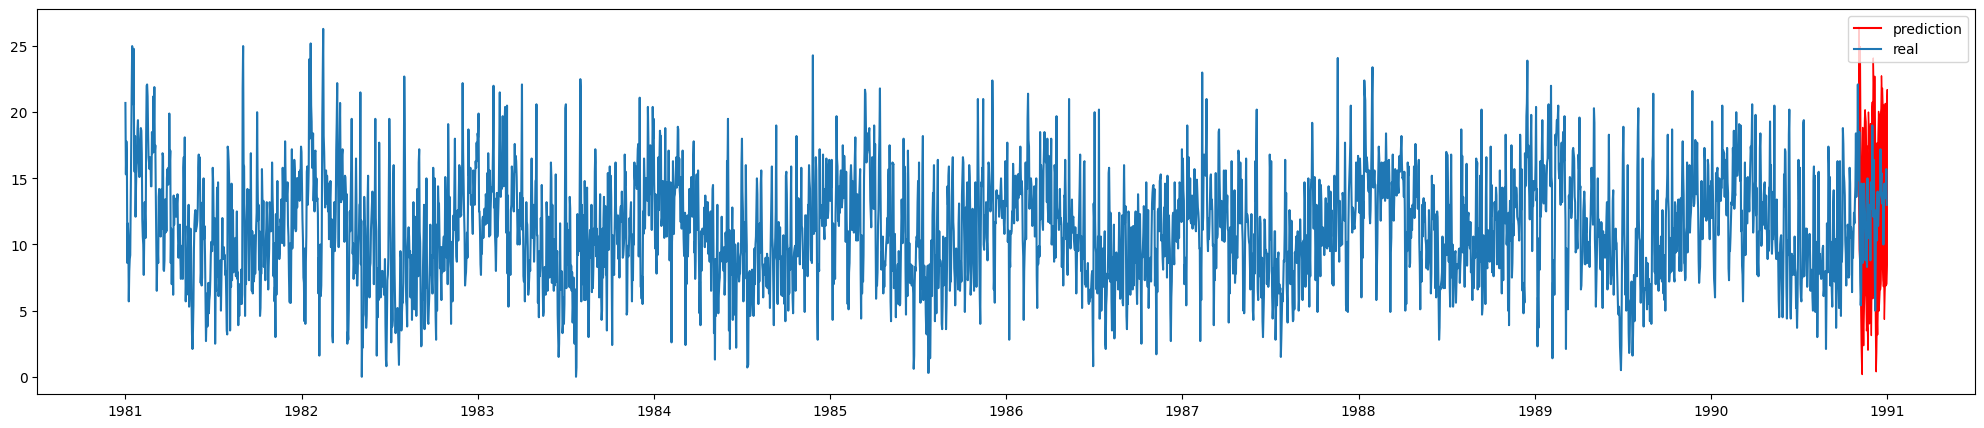

In [40]:
#Comparando as predições com a realidade

plt.figure(figsize=(25,5))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, temp.values, label='real')
plt.legend()
plt.show()

In [42]:
#Calculando a Raiz do Erro Quadrático Médio (RMSE)

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(temp[-60:].values,predicao_media.values))
print(rmse_sarima)

3.012457329818421


In [43]:
from xgboost import XGBRegressor

In [45]:
treino = temp.loc[temp.index <= '1988-12-31']
validacao = temp.loc[temp.index > '1989-01-01']

treino.shape, validacao.shape

((2917, 1), (729, 1))

In [46]:
treino.index.min(), treino.index.max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('1988-12-30 00:00:00'))

In [47]:
validacao.index.min(), validacao.index.max()

(Timestamp('1989-01-02 00:00:00'), Timestamp('1990-12-31 00:00:00'))

In [48]:
treino['Daily minimum temperatures']

Date
1981-01-01    20.7
1981-01-02    15.3
1981-01-03    17.8
1981-01-04    16.7
1981-01-05     8.6
              ... 
1988-12-26     9.5
1988-12-27    12.9
1988-12-28    12.9
1988-12-29    14.8
1988-12-30    14.1
Name: Daily minimum temperatures, Length: 2917, dtype: float64

In [49]:
treino['Daily minimum temperatures'].shift(-1)

Date
1981-01-01    15.3
1981-01-02    17.8
1981-01-03    16.7
1981-01-04     8.6
1981-01-05    11.6
              ... 
1988-12-26    12.9
1988-12-27    12.9
1988-12-28    14.8
1988-12-29    14.1
1988-12-30     NaN
Name: Daily minimum temperatures, Length: 2917, dtype: float64

In [50]:
treino['target'] = treino['Daily minimum temperatures'].shift(-1)
treino.head()

<ipython-input-50-b9bfef1cf32f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['Daily minimum temperatures'].shift(-1)


,Daily minimum temperatures,target
Date,,
1981-01-01,20.7,15.3
1981-01-02,15.3,17.8
1981-01-03,17.8,16.7
1981-01-04,16.7,8.6
1981-01-05,8.6,11.6


In [52]:
treino = treino.dropna()
treino.tail()

,Daily minimum temperatures,target
Date,,
1988-12-25,15.8,9.5
1988-12-26,9.5,12.9
1988-12-27,12.9,12.9
1988-12-28,12.9,14.8
1988-12-29,14.8,14.1


In [53]:
validacao['target'] = validacao['Daily minimum temperatures'].shift(-1)
validacao.head()

<ipython-input-53-2c30723a2fe4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['target'] = validacao['Daily minimum temperatures'].shift(-1)


,Daily minimum temperatures,target
Date,,
1989-01-02,16.1,20.4
1989-01-03,20.4,13.3
1989-01-04,13.3,14.2
1989-01-05,14.2,2.3
1989-01-06,2.3,6.0


In [54]:
validacao = validacao.dropna()
validacao.tail()

,Daily minimum temperatures,target
Date,,
1990-12-26,14.6,14.0
1990-12-27,14.0,13.6
1990-12-28,13.6,13.5
1990-12-29,13.5,15.7
1990-12-30,15.7,13.0


In [55]:
X_treino = treino.loc[:, ['Daily minimum temperatures']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['Daily minimum temperatures']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((2916, 1), (2916, 1), (728, 1), (728, 1))

In [56]:
modelo_xgba = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgba.fit(X_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
validacao.iloc[0]

Daily minimum temperatures    16.1
target                        20.4
Name: 1989-01-02 00:00:00, dtype: float64

In [58]:
predicao = modelo_xgba.predict(X_validacao)
predicao

array([15.417005 , 18.699907 , 13.847666 , 12.732179 ,  2.4038346,
        7.9743795,  5.1031556,  9.0529   , 11.124803 ,  8.577289 ,
       13.67876  , 12.221818 , 12.06902  , 21.064789 , 17.193287 ,
       14.670598 , 12.827073 , 12.668034 , 15.141014 , 13.759762 ,
       13.081112 , 12.100693 , 12.199561 , 13.740797 , 14.392583 ,
       14.812141 , 10.899182 , 14.066709 , 15.483271 , 14.812141 ,
       15.20054  , 14.787813 , 17.449087 , 13.730566 , 14.15704  ,
        4.100042 ,  7.841923 ,  9.06603  ,  9.0529   ,  9.121846 ,
        9.943212 , 17.599804 , 16.199614 , 17.599804 , 17.193287 ,
       17.193287 , 14.672088 , 13.934179 , 13.725538 , 13.081112 ,
       15.417005 , 13.716616 , 11.738921 , 14.392583 , 15.614004 ,
       12.384125 , 15.117035 , 16.225697 , 16.225697 , 13.67876  ,
       18.519087 , 12.732179 , 11.758844 ,  6.7999296,  9.068215 ,
        8.577289 ,  7.1008854,  9.695792 ,  8.841794 , 13.005508 ,
       12.252104 , 13.730566 , 13.081112 , 13.743466 , 11.5574

In [59]:
validacao["pred"] = predicao
validacao.head()

,Daily minimum temperatures,target,pred
Date,,,
1989-01-02,16.1,20.4,15.417005
1989-01-03,20.4,13.3,18.699907
1989-01-04,13.3,14.2,13.847666
1989-01-05,14.2,2.3,12.732179
1989-01-06,2.3,6.0,2.403835


In [60]:
mean_squared_error(X_validacao, predicao)

3.6861781203916792